In [ ]:
import numpy as np
import pandas as pd
import os

In [ ]:
from tensorflow.keras.applications import VGG16, ResNet50, ResNet50V2, Xception

In [ ]:
model = VGG16()

model.summary()

In [ ]:
model = VGG16(input_shape=(32, 32, 3), include_top=False, weights='imagenet')

model.summary()

In [ ]:
print('model:', model)
print('model output:', model.output)

In [ ]:
IMAGE_SIZE = 32
BATCH_SIZE = 64

In [ ]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Conv2D, Dropout, Flatten, Activation, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler

In [ ]:
input_tensor = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
base_model = VGG16(input_tensor=input_tensor, include_top=False, weights='imagenet')
bm_output = base_model.output

x = GlobalAveragePooling2D()(bm_output)
# x = Dropout(rate=0.5)(x)
x = Dense(50, activation='relu')(x)
# x = Dropout(rate=0.2)(x)
output = Dense(10, activation='softmax')(x)

# model = Model(inputs=base_model.input, outputs=output)
model = Model(inputs=input_tensor, outputs=output)

model.summary()

In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd

import random as python_random
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.datasets import cifar10

# seed 를 설정해서 학습시마다 동일한 결과 유도. 불행히도 의도한 대로 동작하지 않음. 
def set_random_seed(seed_value):
    np.random.seed(seed_value)
    python_random.seed(seed_value)
    tf.random.set_seed(seed_value)

# 0 ~ 1사이값의 float32로 변경하는 함수
def get_preprocessed_data(images, labels, scaling=True):
    
    # 학습과 테스트 이미지 array를 0~1 사이값으로 scale 및 float32 형 변형. 
    if scaling:
        images = np.array(images/255.0, dtype=np.float32)
    else:
        images = np.array(images, dtype=np.float32)
        
    labels = np.array(labels, dtype=np.float32)
    
    return images, labels

# 0 ~ 1사이값 float32로 변경하는 함수 호출 한 뒤 OHE 적용 
def get_preprocessed_ohe(images, labels):
    images, labels = get_preprocessed_data(images, labels, scaling=False)
    # OHE 적용 
    oh_labels = to_categorical(labels)
    return images, oh_labels

# 학습/검증/테스트 데이터 세트에 전처리 및 OHE 적용한 뒤 반환 
def get_train_valid_test_set(train_images, train_labels, test_images, test_labels, valid_size=0.15, random_state=2021):
    # 학습 및 테스트 데이터 세트를  0 ~ 1사이값 float32로 변경 및 OHE 적용. 
    train_images, train_oh_labels = get_preprocessed_ohe(train_images, train_labels)
    test_images, test_oh_labels = get_preprocessed_ohe(test_images, test_labels)
    
    # 학습 데이터를 검증 데이터 세트로 다시 분리
    tr_images, val_images, tr_oh_labels, val_oh_labels = train_test_split(train_images, train_oh_labels, test_size=valid_size, random_state=random_state)
    
    return (tr_images, tr_oh_labels), (val_images, val_oh_labels), (test_images, test_oh_labels ) 


# random seed는 2021로 고정.
set_random_seed(2021)
# CIFAR10 데이터 재 로딩 및 Scaling/OHE 전처리 적용하여 학습/검증/데이터 세트 생성. 
(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()
print(train_images.shape, train_labels.shape, test_images.shape, test_labels.shape)

(tr_images, tr_oh_labels), (val_images, val_oh_labels), (test_images, test_oh_labels) = \
    get_train_valid_test_set(train_images, train_labels, test_images, test_labels, valid_size=0.15, random_state=2021)

print(tr_images.shape, tr_oh_labels.shape, val_images.shape, val_oh_labels.shape, test_images.shape, test_oh_labels.shape)

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_generator = ImageDataGenerator(
  horizontal_flip=True,
  rescale=1/255.0
)
valid_generator = ImageDataGenerator(rescale=1/255.0)
test_generator = ImageDataGenerator(rescale=1/255.0)

flow_tr_gen = train_generator.flow(tr_images, tr_oh_labels, batch_size=BATCH_SIZE, shuffle=True)
flow_val_gen = valid_generator.flow(val_images, val_oh_labels, batch_size=BATCH_SIZE, shuffle=False)
flow_test_gen = test_generator.flow(test_images, test_oh_labels, batch_size=BATCH_SIZE, shuffle=False)

In [ ]:
IMAGE_SIZE = 32
BATCH_SIZE = 64

def create_model(verbose=False):
  iinput_tensor = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
  base_model = VGG16(input_tensor=input_tensor, include_top=False, weights='imagenet')
  bm_output = base_model.output

  x = GlobalAveragePooling2D()(bm_output)
  # x = Dropout(rate=0.5)(x)
  x = Dense(50, activation='relu', name='fc1')(x)
  # x = Dropout(rate=0.2)(x)
  output = Dense(10, activation='softmax', name='output')(x)

  model = Model(inputs=input_tensor, outputs=output)

  if verbose: 
    model.summary()
  
  return model 

In [ ]:
vgg_model = create_model(verbose=True)
vgg_model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

rlr_cb = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, mode='min', verbose=1)
ely_cb = EarlyStopping(monitor='val_loss', patience=10, mode='min', verbose=1)

In [ ]:
history = vgg_model.fit(flow_tr_gen, epochs=40, validation_data=flow_val_gen, callbacks=[rlr_cb, ely_cb])

In [ ]:
vgg_model.evaluate(flow_test_gen)

In [ ]:
import matplotlib.pyplot as plt

def show_history(history):
    plt.figure(figsize=(8, 4))
    plt.yticks(np.arange(0, 1, 0.05))
    plt.xticks(np.arange(0, 30, 2))
    plt.plot(history.history['accuracy'], label='train')
    plt.plot(history.history['val_accuracy'], label='valid')
    plt.legend()

In [ ]:
show_history(history)

In [ ]:
import gc

gc.collect()

In [3]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense , Conv2D , Dropout , Flatten , Activation, MaxPooling2D , GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam , RMSprop 
from tensorflow.keras.callbacks import ReduceLROnPlateau , EarlyStopping , ModelCheckpoint , LearningRateScheduler
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import tensorflow as tf
import numpy as np
import pandas as pd
import cv2

import random as python_random
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.datasets import cifar10

from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.applications import Xception

In [4]:
# seed 를 설정해서 학습시마다 동일한 결과 유도. 불행히도 의도한 대로 동작하지 않음. 
def set_random_seed(seed_value):
    np.random.seed(seed_value)
    python_random.seed(seed_value)
    tf.random.set_seed(seed_value)

# 0 ~ 1사이값의 float32로 변경하는 함수
def get_preprocessed_data(images, labels, scaling=True):
    
    # 학습과 테스트 이미지 array를 0~1 사이값으로 scale 및 float32 형 변형. 
    if scaling:
        images = np.array(images/255.0, dtype=np.float32)
    else:
        images = np.array(images, dtype=np.float32)
        
    labels = np.array(labels, dtype=np.float32)
    
    return images, labels

# 0 ~ 1사이값 float32로 변경하는 함수 호출 한 뒤 OHE 적용 
def get_preprocessed_ohe(images, labels):
    images, labels = get_preprocessed_data(images, labels, scaling=False)
    # OHE 적용 
    oh_labels = to_categorical(labels)
    return images, oh_labels

# 학습/검증/테스트 데이터 세트에 전처리 및 OHE 적용한 뒤 반환 
def get_train_valid_test_set(train_images, train_labels, test_images, test_labels, valid_size=0.15, random_state=2021):
    # 학습 및 테스트 데이터 세트를  0 ~ 1사이값 float32로 변경 및 OHE 적용. 
    train_images, train_oh_labels = get_preprocessed_ohe(train_images, train_labels)
    test_images, test_oh_labels = get_preprocessed_ohe(test_images, test_labels)
    
    # 학습 데이터를 검증 데이터 세트로 다시 분리
    tr_images, val_images, tr_oh_labels, val_oh_labels = train_test_split(train_images, train_oh_labels, test_size=valid_size, random_state=random_state)
    
    return (tr_images, tr_oh_labels), (val_images, val_oh_labels), (test_images, test_oh_labels ) 

def get_resized_images(images, resize=64):
    image_cnt = images.shape[0]
    resized_images = np.zeros((images.shape[0], resize, resize, 3))

    for i in range(image_cnt):
        resized_image = cv2.resize(images[i], (resize, resize))
        resized_images[i] = resized_image
        
    return resized_images

def create_model(model_name='vgg16', verbose=False):
    input_tensor = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
    
    if model_name == 'vgg16':
        base_model = VGG16(input_tensor=input_tensor, include_top=False, weights='imagenet')
    elif model_name == 'resnet50':
        base_model = ResNet50V2(input_tensor=input_tensor, include_top=False, weights='imagenet')
    if model_name == 'xception':
        base_model = Xception(input_tensor=input_tensor, include_top=False, weights='imagenet')
    
    bm_output = base_model.output
    
    x = GlobalAveragePooling2D()(bm_output)
    if model_name != 'vgg16':
        x = Dropout(rate=0.5)(x)
    x = Dense(50, activation='relu', name='fc1')(x)
    output = Dense(10, activation='softmax', name='output')(x)
    
    model = Model(inputs=input_tensor, outputs=output)
    if verbose:
        model.summary()
    
    return model

In [5]:
import gc

gc.collect()

23

In [6]:
IMAGE_SIZE = 32
BATCH_SIZE = 64

def do_cifar10_train_evaluation(image_size=IMAGE_SIZE, model_name='vgg16'):
    set_random_seed(2021)
    # CIFAR10 데이터 재 로딩 및 Scaling/OHE 전처리 적용하여 학습/검증/데이터 세트 생성. 
    (train_images, train_labels), (test_images, test_labels) = cifar10.load_data()
    (tr_images, tr_oh_labels), (val_images, val_oh_labels), (test_images, test_oh_labels) = \
        get_train_valid_test_set(train_images, train_labels, test_images, test_labels, valid_size=0.15, random_state=2021)
    print('데이터 세트 shape:', tr_images.shape, tr_oh_labels.shape, val_images.shape, val_oh_labels.shape, test_images.shape, test_oh_labels.shape)
    
    if image_size > 32:
        tr_images = get_resized_images(tr_images)
        val_images = get_resized_images(val_images)
        test_images = get_resized_images(test_images)
    
    train_generator = ImageDataGenerator(horizontal_flip=True, rescale=1/255.0)
    valid_generator = ImageDataGenerator(rescale=1/255.0)
    test_generator = ImageDataGenerator(rescale=1/255.0)
    
    flow_tr_gen = train_generator.flow(tr_images, tr_oh_labels, batch_size=BATCH_SIZE, shuffle=True)
    flow_val_gen = valid_generator.flow(val_images, val_oh_labels, batch_size=BATCH_SIZE, shuffle=False)
    flow_test_gen = test_generator.flow(test_images, test_oh_labels, batch_size=BATCH_SIZE, shuffle=False)
    
    model = create_model(model_name=model_name, verbose=True)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    
    rlr_cb = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, mode='min', verbose=1)
    ely_cb = EarlyStopping(monitor='val_loss', patience=10, mode='min', verbose=1)
    
    history = model.fit(flow_tr_gen, epochs=40, validation_data=flow_val_gen, callbacks=[rlr_cb, ely_cb])
    
    evaluation_result = model.evaluate(flow_test_gen)
    
    return history, evaluation_result
    

In [7]:
history, evaluation_result = do_cifar10_train_evaluation(image_size=64, model_name='xception')

데이터 세트 shape: (42500, 32, 32, 3) (42500, 10) (7500, 32, 32, 3) (7500, 10) (10000, 32, 32, 3) (10000, 10)


2022-09-21 04:24:19.833685: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-21 04:24:19.935803: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-21 04:24:19.936667: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-21 04:24:19.938172: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 15, 15, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 15, 15, 32)   128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 15, 15, 32)   0           block1_conv1_bn[0][0]            
______________________________________________________________________________________________

2022-09-21 04:24:24.210115: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-09-21 04:24:29.194411: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


665/665 [==============================] - 64s 80ms/step - loss: 0.7625 - accuracy: 0.7491 - val_loss: 0.6177 - val_accuracy: 0.8148
Epoch 2/40
665/665 [==============================] - 52s 78ms/step - loss: 0.4014 - accuracy: 0.8688 - val_loss: 0.4255 - val_accuracy: 0.8659
Epoch 3/40
665/665 [==============================] - 51s 77ms/step - loss: 0.3088 - accuracy: 0.8981 - val_loss: 0.4256 - val_accuracy: 0.8729
Epoch 4/40
665/665 [==============================] - 51s 77ms/step - loss: 0.2646 - accuracy: 0.9143 - val_loss: 0.8953 - val_accuracy: 0.7640
Epoch 5/40
665/665 [==============================] - 52s 77ms/step - loss: 0.2467 - accuracy: 0.9200 - val_loss: 0.3461 - val_accuracy: 0.8899
Epoch 6/40
665/665 [==============================] - 52s 78ms/step - loss: 0.1941 - accuracy: 0.9352 - val_loss: 0.3905 - val_accuracy: 0.8769
Epoch 7/40
665/665 [==============================] - 51s 77ms/step - loss: 0.1793 - accuracy: 0.9402 - val_loss: 0.3370 - val_accuracy: 0.8931
Epo

In [8]:
evaluation_result

[0.41942664980888367, 0.9312999844551086]

In [9]:
import matplotlib.pyplot as plt

def show_history(history):
    plt.figure(figsize=(8, 4))
    plt.yticks(np.arange(0, 1, 0.05))
    plt.xticks(np.arange(0, 30, 2))
    plt.plot(history.history['accuracy'], label='train')
    plt.plot(history.history['val_accuracy'], label='valid')
    plt.legend()

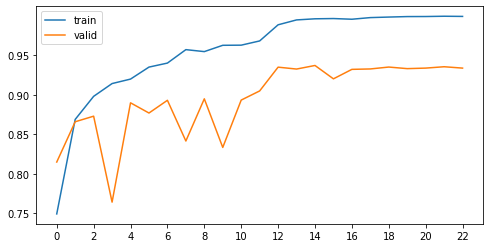

In [10]:
show_history(history)